# I don't understand art and it should be optimised

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*If you believe AI artists are artist, you're wrong, but you'll like this part.*

Linear Quadratic Regulators (LQR) have a special place in my heart. Instead of having a (in some sense) heuristic $K$, smarter people than me came up with the idea of expressing $K$ as the solution to an optimisation problem to obtain *optimal control*. So what optimisation is this? The trick is to balance the control input action and the state deviation, so that calls for the input optimisation
$$\min_u \int_0^\infty x^\intercal (t) Q_x x(t) + u^\intercal(t) Q_u u(t) dt.$$
The $Q$ matrices here are semi-positive weighing matrices, the higher the weight, the more penalised the signal.

The solution to this equation is not easy, but it's found by finding symmetric $S\in\mathbb{R}^{n\times n}, S>0$ such that
$$A^\intercal S + SA - SBQ^{-1}_uB^\intercal S + Q_x = 0,$$
which is called the Algebraic Riccati Equation (ARE). Then with this $S$ we can find $K=Q^{-1}_uB^\intercal S$. Also $u=-Kx$, as a reminder. Lets see if you can beat the optimal control!

<IPython.core.display.Javascript object>

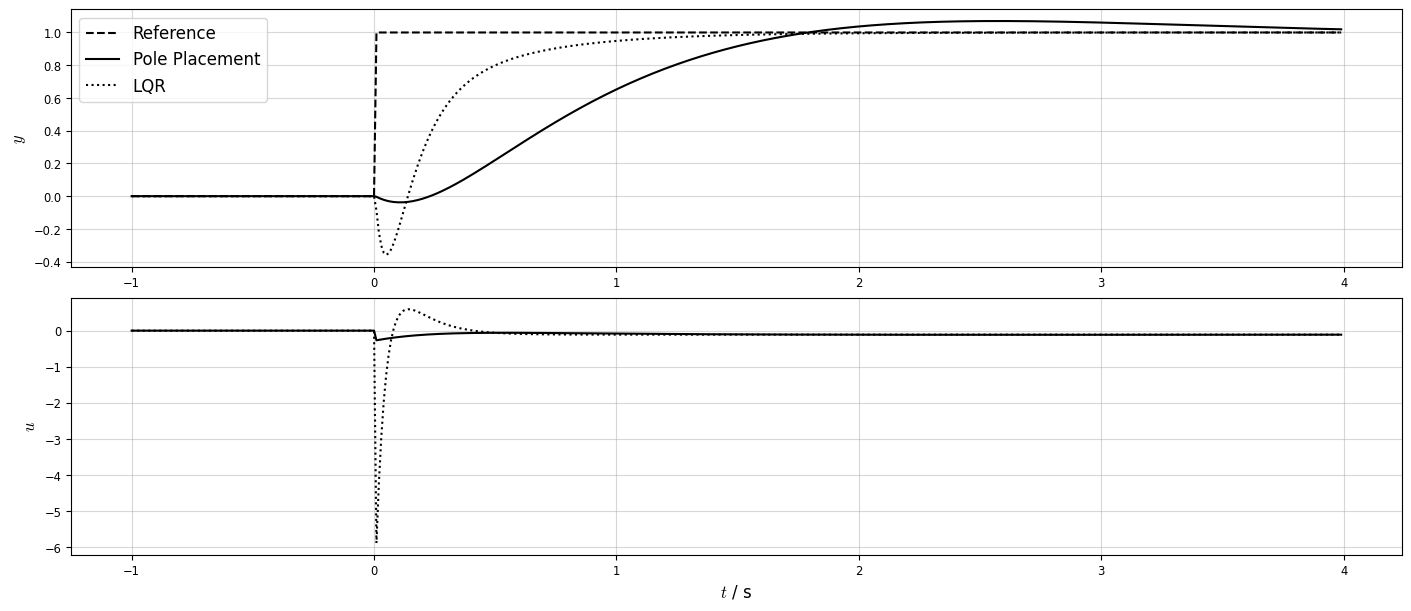

In [7]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()

P_lqr = cm.rss(4, strictly_proper=True)
nx_lqr = len(P_lqr.poles())
x0_lqr = rng.randn(nx_lqr,1)

T_lqr = np.arange(500)*0.01 - 1.
step_lqr = np.zeros_like(T_lqr)
step_lqr[T_lqr > 0.] = 1.

assert isControlable(P_lqr.A, P_lqr.B)==True, "System is uncontrollable D:"

## Pole Placement
CLpoles_pp = [-1+1j, -1-1j, -4-2j, -4+2j] ### CHANGEME

K_pp = cm.place(P_lqr.A, P_lqr.B, CLpoles_pp)
kf_pp = (-1/(P_lqr.C@lin.inv(P_lqr.A - P_lqr.B@K_pp)@P_lqr.B))[0,0]
CL_pp = cm.ss(P_lqr.A-P_lqr.B@K_pp, 
              P_lqr.B*kf_pp, 
              P_lqr.C, 
              P_lqr.D)
response_pp = cm.forced_response(sysdata=CL_pp, 
                                 T=T_lqr, 
                                 U=step_lqr)

## LQR
Qx, Qu = np.eye(nx_lqr)*1e2, np.eye(1)*1 ### CHANGEME

K_lqr, _, _ = cm.lqr(P_lqr.A, P_lqr.B, Qx, Qu) 
kf_lqr = (-1/(P_lqr.C@lin.inv(P_lqr.A - P_lqr.B@K_lqr)@P_lqr.B))[0,0]
CL_lqr = cm.ss(P_lqr.A-P_lqr.B@K_lqr, 
               P_lqr.B*kf_lqr, 
               P_lqr.C, 
               P_lqr.D)
response_lqr = cm.forced_response(sysdata=CL_lqr, 
                                  T=T_lqr, 
                                  U=step_lqr)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_pp.time, response_pp.inputs, 'k--', label="Reference")
ax[0].plot(response_pp.time, response_pp.outputs, 'k', label="Pole Placement")
ax[0].plot(response_lqr.time, response_lqr.outputs, 'k:', label="LQR")
ax[0].legend()
ax[0].set(ylabel="$y$")

ax[1].plot(response_pp.time , (-K_pp  @ response_pp.states)[0,:]  + kf_pp*response_pp.inputs, 'k', label="Pole Placement")
ax[1].plot(response_lqr.time, (-K_lqr @ response_lqr.states)[0,:] + kf_lqr*response_lqr.inputs, 'k:', label="LQR")
ax[1].set(ylabel="$u$", xlabel="$t$ / s")
display(fig)
